# Inflation Rates and Ruling Party

This notebook shows how we can translate a research question into a testable hypothesis, find data and test it empirically.

### 1. Research Question:
Are inflation rates lower when republicans are in office?


### 2. Testable hypothesis:
When the US has a Republican president, inflation rates tend to be lower than when a Democrat is in office.

In [21]:
# Load necessary libraries
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

### 3. Finding Data using FRED
We need to find data on **cpi** and an indicator of the **president's party affiliation**.

In [22]:
# Set up FRED data connection
# Instructions for getting your FRED API key available at these websites
# https://pypi.org/project/fredapi/ 
# http://api.stlouisfed.org/api_key.html
from fredapi import Fred
fred = Fred(api_key='f863382f6b718084247504f94fa5970e')

# Load CPI data for inflation calculation
temp = fred.get_series('CPIAUCSL', observation_start='1960-01-01', observation_end='2023-07-01')
df_cpi = pd.DataFrame(data = temp, columns=['CPI'])
df_cpi = df_cpi.rename_axis('Date').reset_index()

# Calculate year-over-year inflation rate
df_cpi['CPI_12m_lag'] = df_cpi['CPI'].shift(12)
df_cpi['Inflation_Rate'] = ((df_cpi['CPI'] - df_cpi['CPI_12m_lag']) / df_cpi['CPI_12m_lag']) * 100

print("CPI and Inflation Rate Data:")
print(df_cpi.head(15))  # Show first 15 rows to see when inflation calculation starts

CPI and Inflation Rate Data:
         Date    CPI  CPI_12m_lag  Inflation_Rate
0  1960-01-01  29.37          NaN             NaN
1  1960-02-01  29.41          NaN             NaN
2  1960-03-01  29.41          NaN             NaN
3  1960-04-01  29.54          NaN             NaN
4  1960-05-01  29.57          NaN             NaN
5  1960-06-01  29.61          NaN             NaN
6  1960-07-01  29.55          NaN             NaN
7  1960-08-01  29.61          NaN             NaN
8  1960-09-01  29.61          NaN             NaN
9  1960-10-01  29.75          NaN             NaN
10 1960-11-01  29.78          NaN             NaN
11 1960-12-01  29.81          NaN             NaN
12 1961-01-01  29.84        29.37        1.600272
13 1961-02-01  29.84        29.41        1.462088
14 1961-03-01  29.84        29.41        1.462088


In [23]:
# Use the CPI data as our main dataset
df_fred = df_cpi.copy()

# Remove rows where inflation rate cannot be calculated (first 12 months)
df_fred = df_fred.dropna(subset=['Inflation_Rate'])

print("Inflation Data Summary:")
print(df_fred.describe())
print("\nFirst few rows of processed data:")
print(df_fred.head())

Inflation Data Summary:
                                Date         CPI  CPI_12m_lag  Inflation_Rate
count                            751  751.000000   751.000000      751.000000
mean   1992-03-31 23:40:49.533954688  138.480168   134.151911        3.811239
min              1961-01-01 00:00:00   29.810000    29.370000       -1.958761
25%              1976-08-16 12:00:00   57.450000    54.400000        1.884329
50%              1992-04-01 00:00:00  139.400000   135.100000        3.042596
75%              2007-11-16 00:00:00  211.116000   203.268500        4.744804
max              2023-07-01 00:00:00  304.615000   295.072000       14.592275
std                              NaN   79.502382    77.920824        2.843251

First few rows of processed data:
         Date    CPI  CPI_12m_lag  Inflation_Rate
12 1961-01-01  29.84        29.37        1.600272
13 1961-02-01  29.84        29.41        1.462088
14 1961-03-01  29.84        29.41        1.462088
15 1961-04-01  29.81        29.54      

In [24]:
# Read in data files 
# GOP term flags
url = "https://github.com/llorracc/as.180.369/blob/main/materials/presidential-term-data/GOP_flag.csv?raw=true"
# Fix: Specify types for each column
temp = pd.read_csv(url, dtype={'Date': 'str', 'GOP': 'int64'})
df_gop = pd.DataFrame(temp)

# Add a specific day (e.g., the first day of the month)
df_gop['Date'] = df_gop['Date'] + '.01'

# Convert the complete date string to a datetime object
#df_gop['Date'] = datetime.strptime(df_gop['Date'], '%Y-%m-%d')
df_gop['Date'] = pd.to_datetime(df_gop['Date'])
df_gop['Date'] = df_gop['Date'].dt.normalize()
df_gop['Date'] = df_gop['Date'].dt.floor('D')
display(df_gop.head)
display(df_gop.dtypes)

<bound method NDFrame.head of            Date  GOP
0    1871-01-01    1
1    1871-02-01    1
2    1871-03-01    1
3    1871-04-01    1
4    1871-05-01    1
...         ...  ...
1826 2023-03-01    0
1827 2023-04-01    0
1828 2023-05-01    0
1829 2023-06-01    0
1830 2023-07-01    0

[1831 rows x 2 columns]>

Date    datetime64[ns]
GOP              int64
dtype: object

In [25]:
# Create new data frame that merges GOP flag with inflation data
df = pd.merge(df_cpi, df_gop, left_on='Date', right_on='Date')
print(df.head(5))
print(df.tail(5))
display(df.dtypes)

        Date    CPI  CPI_12m_lag  Inflation_Rate  GOP
0 1960-01-01  29.37          NaN             NaN    1
1 1960-01-01  29.37          NaN             NaN    1
2 1960-02-01  29.41          NaN             NaN    1
3 1960-03-01  29.41          NaN             NaN    1
4 1960-04-01  29.54          NaN             NaN    1
          Date      CPI  CPI_12m_lag  Inflation_Rate  GOP
758 2023-03-01  301.643      287.467        4.931349    0
759 2023-04-01  302.858      288.582        4.946947    0
760 2023-05-01  303.316      291.299        4.125315    0
761 2023-06-01  304.099      295.072        3.059253    0
762 2023-07-01  304.615      294.940        3.280328    0


Date              datetime64[ns]
CPI                      float64
CPI_12m_lag              float64
Inflation_Rate           float64
GOP                        int64
dtype: object

Republican average inflation: 4.23%
Democratic average inflation: 3.36%
Difference: 0.88 percentage points


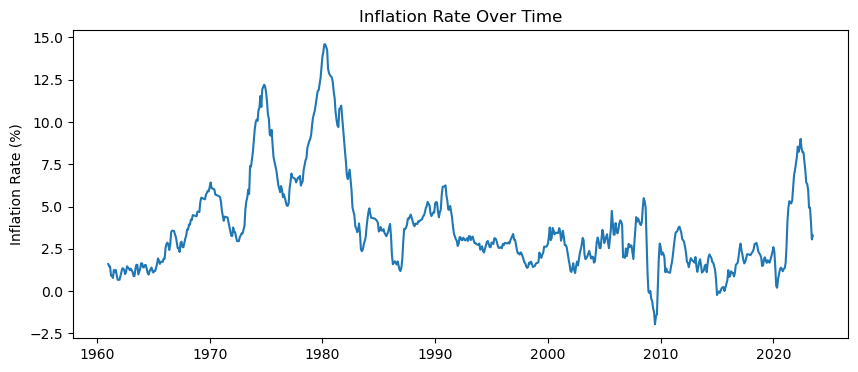

In [26]:
# Simple inflation analysis by party

# Calculate averages
rep_inflation = df[df['GOP'] == 1]['Inflation_Rate'].mean()
dem_inflation = df[df['GOP'] == 0]['Inflation_Rate'].mean()

print(f"Republican average inflation: {rep_inflation:.2f}%")
print(f"Democratic average inflation: {dem_inflation:.2f}%")
print(f"Difference: {rep_inflation - dem_inflation:.2f} percentage points")

# Simple plot
plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['Inflation_Rate'])
plt.title('Inflation Rate Over Time')
plt.ylabel('Inflation Rate (%)')
plt.show()

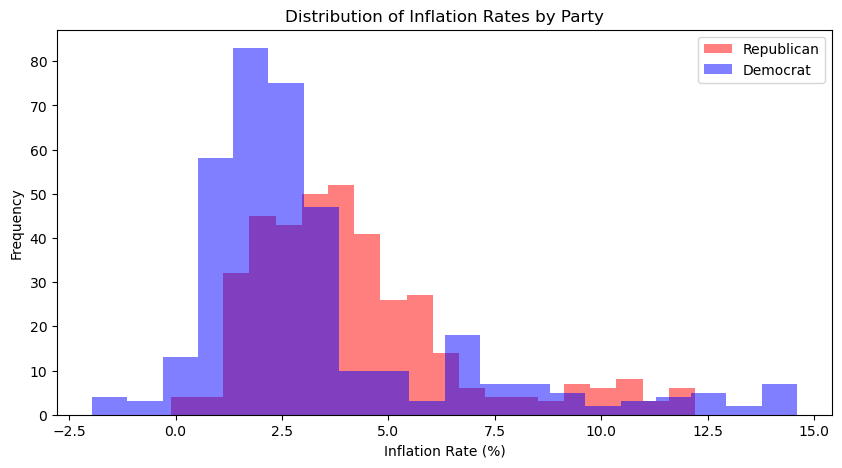

In [27]:
# Distribution comparison
plt.figure(figsize=(10, 5))
plt.hist(df[df['GOP'] ==1]['Inflation_Rate'], alpha=0.5, label='Republican', color='red', bins=20)
plt.hist(df[df['GOP'] ==0]['Inflation_Rate'], alpha=0.5, label='Democrat', color='blue', bins=20)
plt.xlabel('Inflation Rate (%)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Inflation Rates by Party')
plt.show()

### 4. Testing hypothesis empirically with OLS

In [28]:
display(df.dtypes)

df_clean = df.dropna(subset=['Inflation_Rate'])
X = df_clean[['GOP']] # Convert bool to int first
X = sm.add_constant(X)             # Now this should work
y = df_clean['Inflation_Rate']
results = sm.OLS(y, X).fit()
print(results.summary())

Date              datetime64[ns]
CPI                      float64
CPI_12m_lag              float64
Inflation_Rate           float64
GOP                        int64
dtype: object

                            OLS Regression Results                            
Dep. Variable:         Inflation_Rate   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     18.21
Date:                Fri, 03 Oct 2025   Prob (F-statistic):           2.23e-05
Time:                        13:29:41   Log-Likelihood:                -1840.9
No. Observations:                 751   AIC:                             3686.
Df Residuals:                     749   BIC:                             3695.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3567      0.147     22.843      0.0

### 5. Conclusion
Contrary to the hypothesis, inflation rates are significantly higher under Republican administrations (4.23%) compared to Democratic administrations (3.36%), with Republicans experiencing 0.88 percentage points more inflation on average. However, presidential party affiliation explains only 2.4% of inflation variation, suggesting that other economic factors play a much larger role in determining inflation rates.